## Siamese Network for House Recommendation

**Goal**:<br>
build `siamese network`, `contrastive loss`, and `triplet loss` to compare house feature embeddings and provide recommendations. <br>
Add in evaluation sections, plus ensemble models.

**Reference**:<br>
[Siamese Network Keras for Image and Text similarity](https://medium.com/@prabhnoor0212/siamese-network-keras-31a3a8f37d04)<br>
[Home Embeddings for Similar Home Recommendations](https://www.zillow.com/tech/embedding-similar-home-recommendation/)

### STEP 0. Load in packages

In [ ]:
!pip install shap

In [2]:
# import libraries
from __future__ import absolute_import
from __future__ import print_function

import shap
import pickle
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from numpy import dot
from numpy.linalg import norm
from itertools import repeat


import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Conv2D, Input, Dense, Lambda, Layer, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.models import Model


from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.layers import concatenate

from sklearn.metrics.pairwise import cosine_similarity



In [3]:
pd.set_option('display.max_columns', 999)

### Helper Function(s)

In [4]:
def evaluate_model(model,test_data, training_results):
    
    # Get the model train history
    model_train_history = training_results.history
    # Get the number of epochs the training was run for
    num_epochs = len(model_train_history["loss"])

    # Plot training results
    fig, ax = plt.subplots(figsize=(15,5))
    plt.title('Loss')
    # Plot all metrics
    for metric in ["loss","val_loss"]:
        plt.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
    plt.legend()
    
    plt.show()
    
    # Evaluate on test data
    evaluation_results = model.evaluate(test_data)
    print("Evaluation Results:", evaluation_results)

In [5]:
def precision_recall_at_k(k_in):
  # get top k predictions for each ip
  g = all_pairs_predictions.groupby(['ip']).apply(lambda x: x.sort_values(['proba'], ascending = False)).reset_index(drop=True)
  top_k_each = g.groupby('ip').head(k_in)
  recommended_at_k = top_k_each[top_k_each.pred==1].groupby('ip')['rex_url'].apply(list).reset_index()

  recall_results = {}
  precision_results = {}
  #loop through each ip and compare recommended to real test set
  for idx, row in recommended_at_k.iterrows():
    ip_curr = row['ip']
    recommended_at_k_curr = row['rex_url']

    true_for_ip_curr = user_listing_test[user_listing_test.ip==ip_curr].rexUrl.values

    # Recommendations that are relevant
    # find overlap
    correctly_found_ip_curr = list(set(recommended_at_k_curr) & set(true_for_ip_curr))


    recall_results[ip_curr] = len(correctly_found_ip_curr)/len(true_for_ip_curr)
    precision_results[ip_curr] = len(correctly_found_ip_curr)/len(recommended_at_k_curr)

  
  return recommended_at_k, recall_results, precision_results


### Step 1: Prepare Data

In [7]:
cd drive/MyDrive/2020_Fall/Captstone\(297\)

/content/drive/MyDrive/2020_Fall/Captstone(297)


In [57]:
anchor = np.load('./data/anchor_data_window_full.npy',allow_pickle=True)
positive = np.load('./data/pos_data_window_full.npy',allow_pickle=True)
negative = np.load('./data/neg_data_window_full.npy',allow_pickle=True)

print("Loading data:\nAnchor: ", anchor.shape)
print("Positive: ", positive.shape)
print("Negative: ", negative.shape)

Loading data:
Anchor:  (73450, 77)
Positive:  (73450, 77)
Negative:  (73450, 77)


In [58]:
y_train = np.random.randint(0,1, (anchor.shape[0],1))

In [59]:
np.random.seed(297)
train_idx = np.random.choice(np.arange(anchor.shape[0]),size=int(anchor.shape[0]*0.9),replace=False)
anchor_train = anchor[train_idx,:]
pos_train = positive[train_idx,:]
neg_train = negative[train_idx,:]
y_training = y_train[train_idx,:]

anchor_test = np.delete(anchor,train_idx,axis=0)
pos_test = np.delete(positive,train_idx,axis=0)
neg_test = np.delete(negative,train_idx,axis=0)
y_test = np.delete(y_train,train_idx)

print(anchor.shape)
print(anchor_train.shape)
print(anchor_test.shape)


(73450, 77)
(66105, 77)
(7345, 77)


### Step 2: Build Model

#### 2.1 Contrastive Loss

In [149]:
pair_input1 = np.concatenate((anchor_train,anchor_train))
pair_input2 = np.concatenate((pos_train, neg_train))

class0=np.zeros((anchor_train.shape[0],1))
class1=np.ones((anchor_train.shape[0],1))
output = np.concatenate((class1, class0))

pair_input1_val = np.concatenate((anchor_test,anchor_test))
pair_input2_val = np.concatenate((pos_test, neg_test))

class0_val=np.zeros((anchor_test.shape[0],1))
class1_val=np.ones((anchor_test.shape[0],1))
output_val = np.concatenate((class1_val, class0_val))

pair_input1.shape, pair_input2.shape

((132210, 77), (132210, 77))

In [150]:
""" Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
"""

def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

def cosine_distance(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

In [160]:
def create_embedding_model():
    input_shape = (anchor.shape[1],)
    input_listing = Input(shape=input_shape)

    x = Dense(32, activation='relu', input_shape=input_shape, name='dense1')(input_listing)
    #x = Dropout(.2)(x)
    x = BatchNormalization()(x)

    # d1 = Dense(32, activation='relu', input_shape=input_shape, name='dense2')(don1)
    # do1 = Dropout(.2)(d1)
    # do1 = BatchNormalization()(do1)


    bottleneck = Dense(16, activation='linear', input_shape=input_shape, name='dense4')(x)
    

    triplet_model_embedding = Model(input_listing, bottleneck)  
    return triplet_model_embedding

In [161]:
from tensorflow.keras.layers import concatenate

input_shape = (anchor.shape[1],)
# Create the 2 inputs
input1 = Input(shape=input_shape, name='target')
input2 = Input(shape=input_shape, name='candidate')

# Share base network with the 2 inputs
contrastive_model_embedding = create_embedding_model()
input1_embedding = contrastive_model_embedding(input1)       
input2_embedding = contrastive_model_embedding(input2)       

L1_layer = Lambda(cosine_distance)
L1_distance = L1_layer([input1_embedding, input2_embedding])

# Add a dense layer with a sigmoid unit to generate the similarity score
prediction = Dense(1,activation='sigmoid')(L1_distance)

# Define the trainable model
model = Model(inputs=[input1, input2], 
              outputs=prediction)

model.compile(optimizer=Adam(0.001),
              loss=contrastive_loss)#
print(model.summary())

# Training the model
training_results =  model.fit(x=(pair_input1,pair_input2),y=output, 
                              validation_data=((pair_input1_val,pair_input2_val), output_val), 
                              batch_size=256, epochs=5)

Model: "functional_57"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
target (InputLayer)             [(None, 77)]         0                                            
__________________________________________________________________________________________________
candidate (InputLayer)          [(None, 77)]         0                                            
__________________________________________________________________________________________________
functional_55 (Functional)      (None, 16)           3152        target[0][0]                     
                                                                 candidate[0][0]                  
__________________________________________________________________________________________________
lambda_13 (Lambda)              (None, 1)            0           functional_55[0][0]  

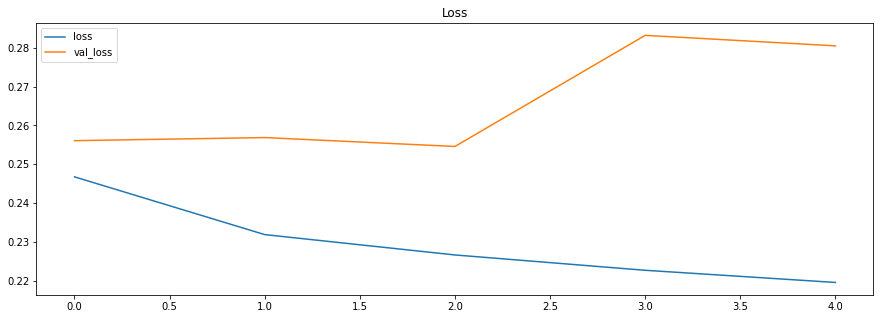

4132/4132 [==============================] - 4s 1ms/step - loss: 0.0000e+00
Evaluation Results: 0.0


In [162]:
evaluate_model(model,(pair_input1,pair_input2), training_results)

In [163]:
house1 = contrastive_model_embedding.predict(anchor_test)
house2 = contrastive_model_embedding.predict(pos_test)
house3 = contrastive_model_embedding.predict(neg_test)

cos_sim_all = []
for h1, h2, h3 in zip(house1, house2, house3):
  cos_sim_pos = dot(h1, h2)/(norm(h1)*norm(h2))
  cos_sim_neg = dot(h1, h3)/(norm(h1)*norm(h3))
  cos_sim_all.append(cos_sim_pos-cos_sim_neg)

cos_sim_all = np.array(cos_sim_all)
pos_is_high_sum = sum(cos_sim_all>0)
pos_is_high_sum/len(anchor_test)

0.786929884275017

In [164]:
pos_is_high_sum = 0
for i in range(3):
    house1 = contrastive_model_embedding.predict(anchor_test[i:i+1])
    house2 = contrastive_model_embedding.predict(pos_test[i:i+1])
    house3 = contrastive_model_embedding.predict(neg_test[i:i+1])
    pos_score = cosine_similarity(house1, house2)
    neg_score = cosine_similarity(house1, house3)
    pos_is_high = 1 if pos_score>neg_score else 0
    pos_is_high_sum += pos_is_high
    print(f"Pair {i}: is_pose_high = ", pos_is_high)
    print("Compare two positive house: ", pos_score)
    print("Compare two negative house: ", neg_score)

Pair 0: is_pose_high =  1
Compare two positive house:  [[0.9950239]]
Compare two negative house:  [[0.9775199]]
Pair 1: is_pose_high =  1
Compare two positive house:  [[0.9950239]]
Compare two negative house:  [[0.98111886]]
Pair 2: is_pose_high =  1
Compare two positive house:  [[0.9950239]]
Compare two negative house:  [[0.714604]]


In [165]:
contrastive_model_embedding.save('save_model/contrastive_model_embedding_window_full_3') 
# save_model/triplet_model_embedding_toy

INFO:tensorflow:Assets written to: save_model/contrastive_model_embedding_window_full_3/assets


#### 2.2 Triplet Loss

In [119]:
def create_embedding_model():
    input_shape = (anchor.shape[1],)
    input_listing = Input(shape=input_shape)

    x = Dense(32, activation='relu', input_shape=input_shape, name='dense1')(input_listing)
    #x = Dropout(.2)(x)
    x = BatchNormalization()(x)

    # d2 = Dense(16, activation='relu', input_shape=input_shape, name='dense3')(do1)
    # do2 = Dropout(.1)(d2)
    # do2 = BatchNormalization()(do2)

    bottleneck = Dense(16, activation='linear', input_shape=input_shape, name='dense4')(x)
    

    triplet_model_embedding = Model(input_listing, bottleneck)  
    return triplet_model_embedding

In [120]:
def triplet_loss(x, ALPHA=0.75):

    anchor, positive, negative = x
    
    #Modifying the triplet loss
    anchor = 2*anchor

    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), 1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), 1)

    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), ALPHA)
    loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0), 0)
    loss = tf.divide(tf.maximum(loss, 0.0), 2.0) #??

    #Return max(0, loss)
    return loss

In [122]:
input_shape = (anchor.shape[1],)
triplet_model_embedding = create_embedding_model()

anchor_example = Input(shape=input_shape, name='anchor')
positive_example = Input(shape=input_shape, name='positive')
negative_example = Input(shape=input_shape, name='negative')

positive_embedding = triplet_model_embedding(positive_example)       
negative_embedding = triplet_model_embedding(negative_example)       
anchor_embedding = triplet_model_embedding(anchor_example)           

#The Triplet Model which optimizes over the triplet loss.       
loss = Lambda(triplet_loss, output_shape=(1,))([anchor_embedding, positive_embedding, negative_embedding])
triplet_model = Model(inputs=[anchor_example, positive_example, negative_example], 
                      outputs=loss)

adam_opt = tf.optimizers.Adam(lr=0.001)           
                                                                
display(triplet_model.summary())

triplet_model.compile(loss='mean_absolute_error', optimizer=adam_opt)
training_results = triplet_model.fit(x=(anchor,positive,negative),y=y_train, 
                                     validation_data=((anchor,positive,negative), y_train), 
                                     batch_size=128, epochs=5)

Model: "functional_45"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor (InputLayer)             [(None, 77)]         0                                            
__________________________________________________________________________________________________
positive (InputLayer)           [(None, 77)]         0                                            
__________________________________________________________________________________________________
negative (InputLayer)           [(None, 77)]         0                                            
__________________________________________________________________________________________________
functional_43 (Functional)      (None, 16)           3152        positive[0][0]                   
                                                                 negative[0][0]       

None

Epoch 1/5
574/574 [==============================] - 2s 3ms/step - loss: 0.6118 - val_loss: 0.4837
Epoch 2/5
574/574 [==============================] - 2s 3ms/step - loss: 0.1224 - val_loss: 0.2335
Epoch 3/5
574/574 [==============================] - 2s 3ms/step - loss: 0.0727 - val_loss: 0.4575
Epoch 4/5
574/574 [==============================] - 2s 3ms/step - loss: 0.0684 - val_loss: 0.2344
Epoch 5/5
574/574 [==============================] - 2s 3ms/step - loss: 0.0651 - val_loss: 0.2421


In [125]:
triplet_model_embedding.save('save_model/triplet_model_embedding_window_full_4') 

INFO:tensorflow:Assets written to: save_model/triplet_model_embedding_window_full_4/assets


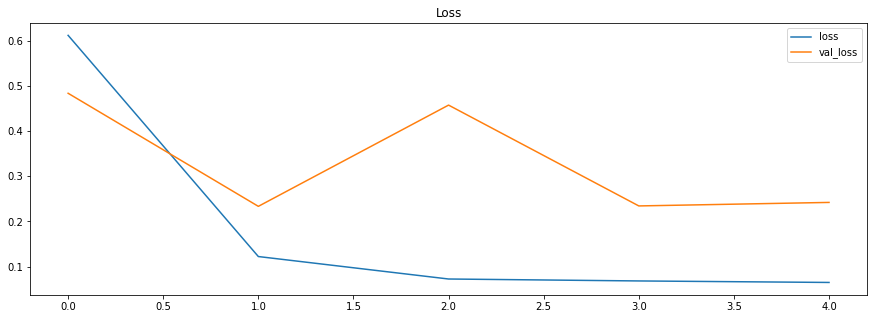

2296/2296 [==============================] - 3s 1ms/step - loss: 0.0000e+00
Evaluation Results: 0.0


In [123]:
evaluate_model(triplet_model,(anchor,positive,negative), training_results)

In [124]:
house1 = triplet_model_embedding.predict(anchor_test)
house2 = triplet_model_embedding.predict(pos_test)
house3 = triplet_model_embedding.predict(neg_test)

cos_sim_all = []
for h1, h2,h3 in zip(house1, house2, house3):
  cos_sim_pos = dot(h1, h2)/(norm(h1)*norm(h2))
  cos_sim_neg = dot(h1, h3)/(norm(h1)*norm(h3))
  cos_sim_all.append(cos_sim_pos-cos_sim_neg)

cos_sim_all = np.array(cos_sim_all)
pos_is_high_sum = sum(cos_sim_all>0)
pos_is_high_sum/len(anchor_test)

0.7993192648059905

In [239]:
## cos similarity 
pos_scores = cosine_similarity(anchor_test, pos_test)
pos_scores = np.diag(pos_scores)

neg_scores = cosine_similarity(anchor_test, neg_test)
neg_scores = np.diag(neg_scores)

pos_is_high_sum = sum(pos_scores>neg_scores)
pos_is_high_sum/len(anchor_test)

0.5380530973451327

In [73]:
pos_is_high_sum = 0
for i in range(3):
    house1 = triplet_model_embedding.predict(anchor_test[i:i+1])
    house2 = triplet_model_embedding.predict(pos_test[i:i+1])
    house3 = triplet_model_embedding.predict(neg_test[i:i+1])
    pos_score = cosine_similarity(house1, house2)
    neg_score = cosine_similarity(house1, house3)
    pos_is_high = 1 if pos_score>neg_score else 0
    pos_is_high_sum += pos_is_high
    print(f"Pair {i}: is_pose_high = ", pos_is_high)
    print("Compare two positive house: ", pos_score)
    print("Compare two negative house: ", neg_score)

Pair 0: is_pose_high =  1
Compare two positive house:  [[0.99553233]]
Compare two negative house:  [[0.99538183]]
Pair 1: is_pose_high =  1
Compare two positive house:  [[0.99553233]]
Compare two negative house:  [[0.99392873]]
Pair 2: is_pose_high =  1
Compare two positive house:  [[0.99553233]]
Compare two negative house:  [[0.9608447]]


### Step 3: Interpretation

In [62]:
def get_shap_interpretation(model_nm, input_data, pick_k=100, max_display=20):
    # select a set of background examples to take an expectation over
    rand_idx = np.random.choice(input_data.shape[0], pick_k, replace=False)
    background = input_data[rand_idx]

    # explain predictions of the model on four images
    e = shap.DeepExplainer(model_nm, background)
    shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough
    shap_values = e.explainer.shap_values(input_data[1:100])
    # plot the feature attributions
    # max_display = 20 # only bar works
    shap.summary_plot(shap_values, anchor[1:100], 
                      plot_type="bar", max_display=max_display) 

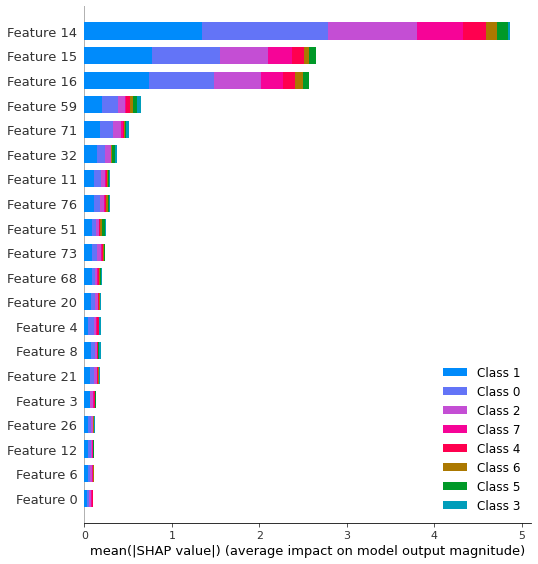

In [349]:
# plot the feature attributions
get_shap_interpretation(contrastive_model_embedding, anchor, pick_k=200, max_display=20)

In [234]:
# house features
pkl_file = open('data/listing_dict.pkl', 'rb')
listing_dict = pickle.load(pkl_file)
pkl_file.close()

listing_df = pd.DataFrame.from_dict(listing_dict, orient='index')
print("Load in listing info: ", listing_df.shape)

Load in listing info:  (5575, 77)


In [350]:
top20 = listing_df.columns[[0,1,3,4,6,8]]

for col in top20:
    print(col)

total_baths
stories
has_jacuzzi
has_pool
has_garage
full_baths


### Step 4: Evaluation

Load in pre-trained model(s)

In [8]:
print("Load in pretrained models")
MODEL_NAME = "save_model/triplet_model_embedding_window_full"
triplet_model_embedding = tf.keras.models.load_model(MODEL_NAME)

Load in pretrained models


Load in true visiting history of each ip

In [9]:
# read python dict back from the file
# test house
pkl_file = open('data/ip_listing_temporal_test_full.pkl', 'rb')
user_listing_test = pickle.load(pkl_file)
print(user_listing_test.shape)
display(user_listing_test.head(2))
pkl_file.close()

(17102, 2)


,ip,rexUrl
11,1.129.109.119,22127-buena-ventura-st
65,1.65.170.128,6151-orange-st-apt-118


#### 4.1 Prepare evaluation data:

Load in all unseen pairs:
$$\{mean_{ip}, unseen\ listing\}$$
Calculate cos-similarit of embeddings

##### 4.1.1. Single model

In [167]:
is_cos = False
cos_sim_all = np.array([])
ips = np.array([])
rex_urls = np.array([])

In [168]:
row_size = 15000
num_chunks = 3985898//row_size
df_chunks = pd.read_csv("./data/user_medianed_paired_unseen.csv",sep=',', 
                          chunksize=row_size)

print("Load in unseen pairs chunk by chunk: ")
for eval_df in tqdm(df_chunks):
  ips = np.concatenate([ips, eval_df.ip])
  rex_urls = np.concatenate([rex_urls, eval_df.rex_url])
  wanted_cols = eval_df.columns.difference(['Unnamed: 0','ip','rex_url'], sort=False)
  
  if is_cos:
    anchor_embd = eval_df[wanted_cols].iloc[:, :77].values
    house_candidate_embd = eval_df[wanted_cols].iloc[:, 77:].values
  else:
    anchor_embd = triplet_model_embedding.predict(eval_df[wanted_cols].iloc[:, :77].values)
    house_candidate_embd = triplet_model_embedding.predict(eval_df[wanted_cols].iloc[:, 77:].values)
  
  cos_sim_scores = cosine_similarity(anchor_embd, house_candidate_embd)
  cos_sim_scores = np.diag(cos_sim_scores)
  cos_sim_all = np.concatenate([cos_sim_all, cos_sim_scores.flatten()])


cos_sim_all = np.array(cos_sim_all)

0it [00:00, ?it/s]

Load in unseen pairs chunk by chunk: 


266it [05:53,  1.33s/it]


In [169]:
temporal_pred = np.ones(cos_sim_all.shape)

# Create prediction result table
all_pairs_predictions = pd.DataFrame({'ip':ips,'rex_url':rex_urls,'proba':cos_sim_all,'pred':temporal_pred})
all_pairs_predictions.sort_values('proba',ascending=False,inplace=True)
all_pairs_predictions.reset_index(drop=True,inplace=True)

In [170]:
# Save result "triplet" "contrastive", "contrastive2", "cos_sim"
all_pairs_predictions.to_pickle('./save_model/contrastive3_all_pairs_predictions.pkl')

##### 4.1.2 Prepare Ensemble Model

In [10]:
ensemble_method = "rank" # "add_cos","rank"

In [11]:
file_ls = ['triplet']#,'triplet3','triplet4']#['contrastive','contrastive2'] #'triplet',
ensemble_prob = np.array([])

# load in features
for file_nm in file_ls:
  pkl_file = open(f'./save_model/{file_nm}_all_pairs_predictions.pkl', 'rb')
  curr_model = pickle.load(pkl_file)
  pkl_file.close()
  if ensemble_prob.shape[0]:
    if ensemble_method=="rank":
      ensemble_prob += curr_model.groupby("ip")["proba"].rank(method='dense')
    if ensemble_method=="add_cos":
      ensemble_prob += curr_model.proba.values
  else:
    if ensemble_method=="rank":
      ensemble_prob = curr_model.groupby("ip")["proba"].rank(method='dense')
    if ensemble_method=="add_cos":
      ensemble_prob = curr_model.proba.values

ips = curr_model.ip.values
rex_urls = curr_model.rex_url.values

In [12]:
temporal_pred = np.ones(ensemble_prob.shape)

# Create prediction result table
all_pairs_predictions = pd.DataFrame({'ip':ips,'rex_url':rex_urls,'proba':ensemble_prob,'pred':temporal_pred})
all_pairs_predictions.sort_values('proba',ascending=False,inplace=True)
all_pairs_predictions.reset_index(drop=True,inplace=True)

#### 4.2 Calculate

In [21]:
def precision_recall_at_k(k_in):
  # get top k predictions for each ip
  g = all_pairs_predictions.groupby(['ip']).apply(lambda x: x.sort_values(['proba'], ascending = False)).reset_index(drop=True)
  top_k_each = g.groupby('ip').head(k_in)
  recommended_at_k = top_k_each[top_k_each.pred==1].groupby('ip')['rex_url'].apply(list).reset_index()

  recall_results = {}
  precision_results = {}
  #loop through each ip and compare recommended to real test set
  for idx, row in recommended_at_k.iterrows():
    ip_curr = row['ip']
    recommended_at_k_curr = row['rex_url']

    true_for_ip_curr = user_listing_test[user_listing_test.ip==ip_curr].rexUrl.values

    # Recommendations that are relevant
    # find overlap
    correctly_found_ip_curr = list(set(recommended_at_k_curr) & set(true_for_ip_curr))

    if (len(correctly_found_ip_curr)>0) & (len(true_for_ip_curr)>=2)& (len(true_for_ip_curr)<=6):
      print(ip_curr)
      print(correctly_found_ip_curr)
      break
    recall_results[ip_curr] = len(correctly_found_ip_curr)/len(true_for_ip_curr)
    precision_results[ip_curr] = len(correctly_found_ip_curr)/len(recommended_at_k_curr)

  
  return recommended_at_k, recall_results, precision_results


In [ ]:
precision_recall_at_k(10)

In [ ]:
k_ls = [10, 20,30,50]

for k in k_ls:
  recommended_at_10, recall_at_10, precision_at_10 = precision_recall_at_k(k)
  print(f'precision @ {k}', np.mean(list(precision_at_10.values())))
  print(f'recall @ {k}', np.mean(list(recall_at_10.values())))
  print("\n")

#### 4.3 Case study

In [30]:
case_ip = "100.1.133.99" #"104.173.194.23" #"104.1.138.21" #
ip_candidate_df = all_pairs_predictions.loc[all_pairs_predictions.ip==case_ip]
ip_candidate_df.reset_index(drop=True, inplace=True)
print("Top 3 recommendation")
display(ip_candidate_df.head(3))
print("Actual Visit")
display(user_listing_test.loc[user_listing_test.ip==case_ip])

Top 3 recommendation


,ip,rex_url,proba,pred
0,100.1.133.99,1219-dell-dr,462.0,1.0
1,100.1.133.99,22633-sylvan-st,461.0,1.0
2,100.1.133.99,8719-topanga-canyon-blvd,460.0,1.0


Actual Visit


,ip,rexUrl
86,100.1.133.99,8719-topanga-canyon-blvd


In [31]:
train_la = pd.read_pickle("./data/ip_listing_temporal_train_full.pkl")
listing_data = pd.read_pickle('./data/LOG_siamese_data_11_12.pkl')


iptest = case_ip
training_case = train_la[train_la.ip==iptest].merge(listing_data,left_on='rexUrl',right_on='rex_url',how='left')
training_case['sqft'] = np.exp(training_case['log_sqft']).map('{:,.0f}'.format)
training_case['price'] = np.exp(training_case['log_price']).map('{:,.0f}'.format)
training_case['total_rooms'] = np.exp(training_case['log_total_rooms'])
cols = ['rex_url','sqft','price','bedrooms','total_rooms','full_baths','is_apt']

training_case[cols]

,rex_url,sqft,price,bedrooms,total_rooms,full_baths,is_apt
0,5418-geyser-ave,"1,313","799,000",3.0,6.0,2.0,0.0
1,1415-n-myers-st,"1,782","840,000",5.0,5.0,3.0,0.0
2,8450-denise-ln,"1,776","660,000",3.0,7.0,2.0,0.0
3,9323-alcott-st-apt-101,"2,588","1,329,999",5.0,17.0,5.0,1.0


In [32]:
test_la = pd.read_pickle("./data/ip_listing_temporal_test_full.pkl")

testing_case = test_la[test_la.ip==iptest].merge(listing_data,left_on='rexUrl',right_on='rex_url',how='left')
testing_case['sqft'] = np.exp(testing_case['log_sqft']).map('{:,.0f}'.format)
testing_case['price'] = np.exp(testing_case['log_price']).map('{:,.0f}'.format)
testing_case['total_rooms'] = np.exp(testing_case['log_total_rooms'])

testing_case[cols]

,rex_url,sqft,price,bedrooms,total_rooms,full_baths,is_apt
0,8719-topanga-canyon-blvd,"2,144","719,000",4.0,8.0,3.0,0.0


In [33]:
ip_candidate_df.loc[ip_candidate_df.rex_url.isin(["8719-topanga-canyon-blvd"])]

,ip,rex_url,proba,pred
2,100.1.133.99,8719-topanga-canyon-blvd,460.0,1.0
